In [6]:
import getml
import matplotlib.pyplot as plt
%matplotlib inline  
 
getml.engine.launch()
getml.engine.set_project('robot')

Launching ./getML --allow-push-notifications=true --allow-remote-ips=false --home-directory=/home/jbris/.getML --in-memory=true --install=false --launch-browser=true --log=false --project-directory=/home/jbris/.getML/projects in /mnt/c/Users/james/projects/auto-feature-engineering/.venv/lib/python3.10/site-packages/getml/.getML/getml-community-1.5.1-amd64-linux...
Launched the getML Engine. The log output will be stored in /home/jbris/.getML/logs/getml_20250808125838.log


Connected to project 'robot'.

In [7]:
data_all = getml.data.DataFrame.from_csv(
    "https://static.getml.com/datasets/robotarm/robot-demo.csv", 
    "data_all"
)
data_all

name              3              4              5              6   ...            105            106            f_x
 role   unused_float   unused_float   unused_float   unused_float   ...   unused_float   unused_float   unused_float
    0         3.4098        -0.3274         0.9604        -3.7436   ...         47.955         47.971        -11.03 
    1         3.4098        -0.3274         0.9604        -3.7436   ...         47.955         47.971        -10.848
    2         3.4098        -0.3274         0.9604        -3.7436   ...         47.955         47.971        -10.666
    3         3.4098        -0.3274         0.9604        -3.7436   ...         47.955         47.971        -10.507
    4         3.4098        -0.3274         0.9604        -3.7436   ...         47.955         47.971        -10.413
             ...            ...            ...            ...                   ...            ...            ...   
14996         3.0837        -0.8836         1.4501        -2.2102   ...         47.94          47.94          10.84 
14997         3.0835        -0.884          1.4505        -2.2091   ...         47.94          47.94          10.857
14998         3.0833        -0.8844         1.4508        -2.208    ...         47.94          47.94          10.89 
14999         3.0831        -0.8847         1.4511        -2.2071   ...         47.94          47.94          11.29 
15000         3.0829        -0.885          1.4514        -2.2062   ...         47.94          47.955         11.69 

 name            f_y            f_z
 role   unused_float   unused_float
    0         6.9           -7.33  
    1         6.7218        -7.4427
    2         6.5436        -7.5555
    3         6.4533        -7.65  
    4         6.6267        -7.69  
             ...            ...    
14996        -1.41          16.14  
14997        -1.52          15.943 
14998        -1.74          15.55  
14999        -1.4601        15.743 
15000        -1.1801        15.937 


15001 rows x 96 columns
memory usage: 11.52 MB
type: getml.DataFrame

In [9]:
data_all.set_role(["f_x", "f_y", "f_z"], getml.data.roles.target)
data_all.set_role(data_all.roles.unused, getml.data.roles.numerical)

In [10]:
split = getml.data.split.time(data_all, "rowid", test=10500)
split

,
0,train
1,train
2,train
3,train
4,train
,...


In [11]:


time_series = getml.data.TimeSeries(
    population=data_all,
    split=split,
    time_stamps="rowid",
    lagged_targets=False,
    memory=30,
)

time_series


data model

  population:
    columns:
    - 3: numerical
    - 4: numerical
    - 5: numerical
    - 6: numerical
    - 7: numerical
    - ...

    joins:
    - right: 'data_all'
      on: 
      - (population.None, data_all.None)
      time_stamps: (population.rowid, data_all.rowid)
      relationship: 'many-to-many'
      memory: 30
      lagged_targets: False

  data_all:
    columns:
    - 3: numerical
    - 4: numerical
    - 5: numerical
    - 6: numerical
    - 7: numerical
    - ...


container

  population
      subset   name        rows   type
  0   test     data_all    4501   View
  1   train    data_all   10500   View

  peripheral
      name        rows   type
  0   data_all   15001   View

In [12]:
fast_prop = getml.feature_learning.FastProp(
    loss_function=getml.feature_learning.loss_functions.SquareLoss,
    num_features=10,
)

xgboost = getml.predictors.XGBoostRegressor()

pipe1 = getml.pipeline.Pipeline(
    data_model=time_series.data_model,
    feature_learners=[fast_prop],
    predictors=xgboost
)

In [15]:
pipe1.check(time_series.train)
pipe1.fit(time_series.train)

Checking data model...

OK.

Checking data model...

OK.

Trained pipeline.

Time taken: 0:00:00.377591.



Pipeline(data_model='population',
         feature_learners=['FastProp'],
         feature_selectors=[],
         include_categorical=False,
         loss_function='SquareLoss',
         peripheral=['data_all'],
         predictors=['XGBoostRegressor'],
         preprocessors=[],
         share_selected_features=0.5,
         tags=['container-dNDu28', 'container-dNDu28', 'container-dNDu28'])

In [16]:
pipe1.score(time_series.test)

,date time,set used,target,mae,rmse,rsquared
0,2025-08-08 12:59:40,train,f_x,0.4403,0.58,0.9962
1,2025-08-08 12:59:40,train,f_y,0.5168,0.6813,0.9893
2,2025-08-08 12:59:40,train,f_z,0.2918,0.385,0.9986
3,2025-08-08 12:59:40,test,f_x,0.5605,0.7319,0.995
4,2025-08-08 12:59:40,test,f_y,0.5653,0.7532,0.9871
5,2025-08-08 12:59:40,test,f_z,0.3131,0.4071,0.9984


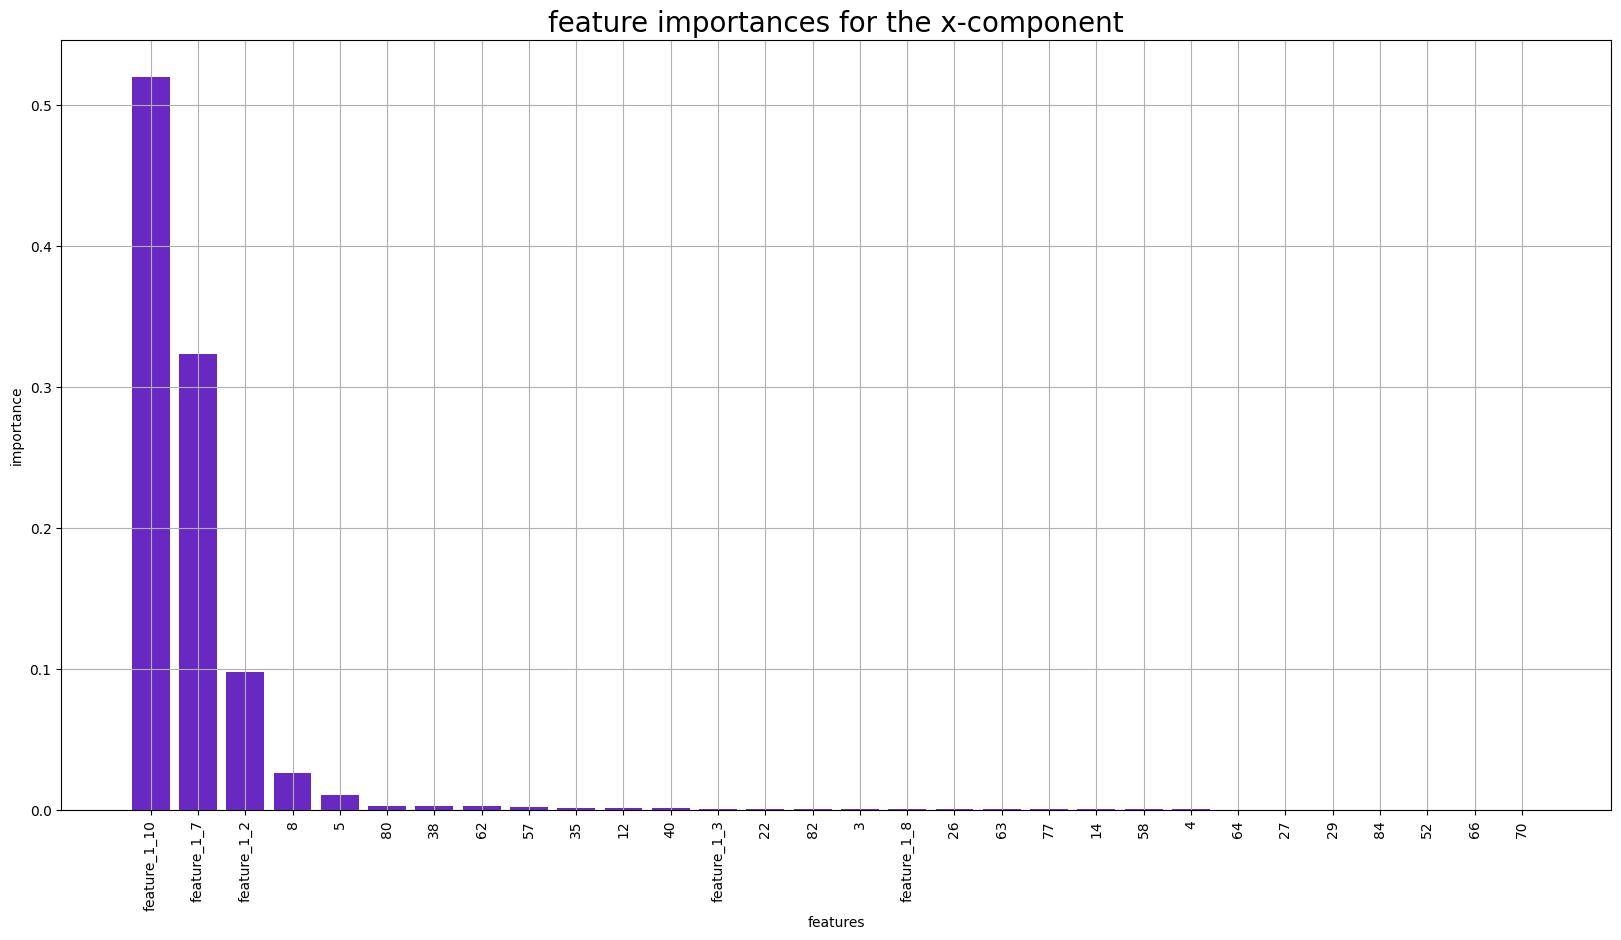

In [17]:
plt.subplots(figsize=(20, 10))

names, importances = pipe1.features.importances(target_num=0)

plt.bar(names[0:30], importances[0:30], color='#6829c2')

plt.title("feature importances for the x-component", size=20)
plt.grid(True)
plt.xlabel("features")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()plt.subplots(figsize=(20, 10))

names, importances = pipe1.features.importances(target_num=1)

plt.bar(names[0:30], importances[0:30], color='#6829c2')

plt.title("feature importances for the y-component", size=20)
plt.grid(True)
plt.xlabel("features")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()

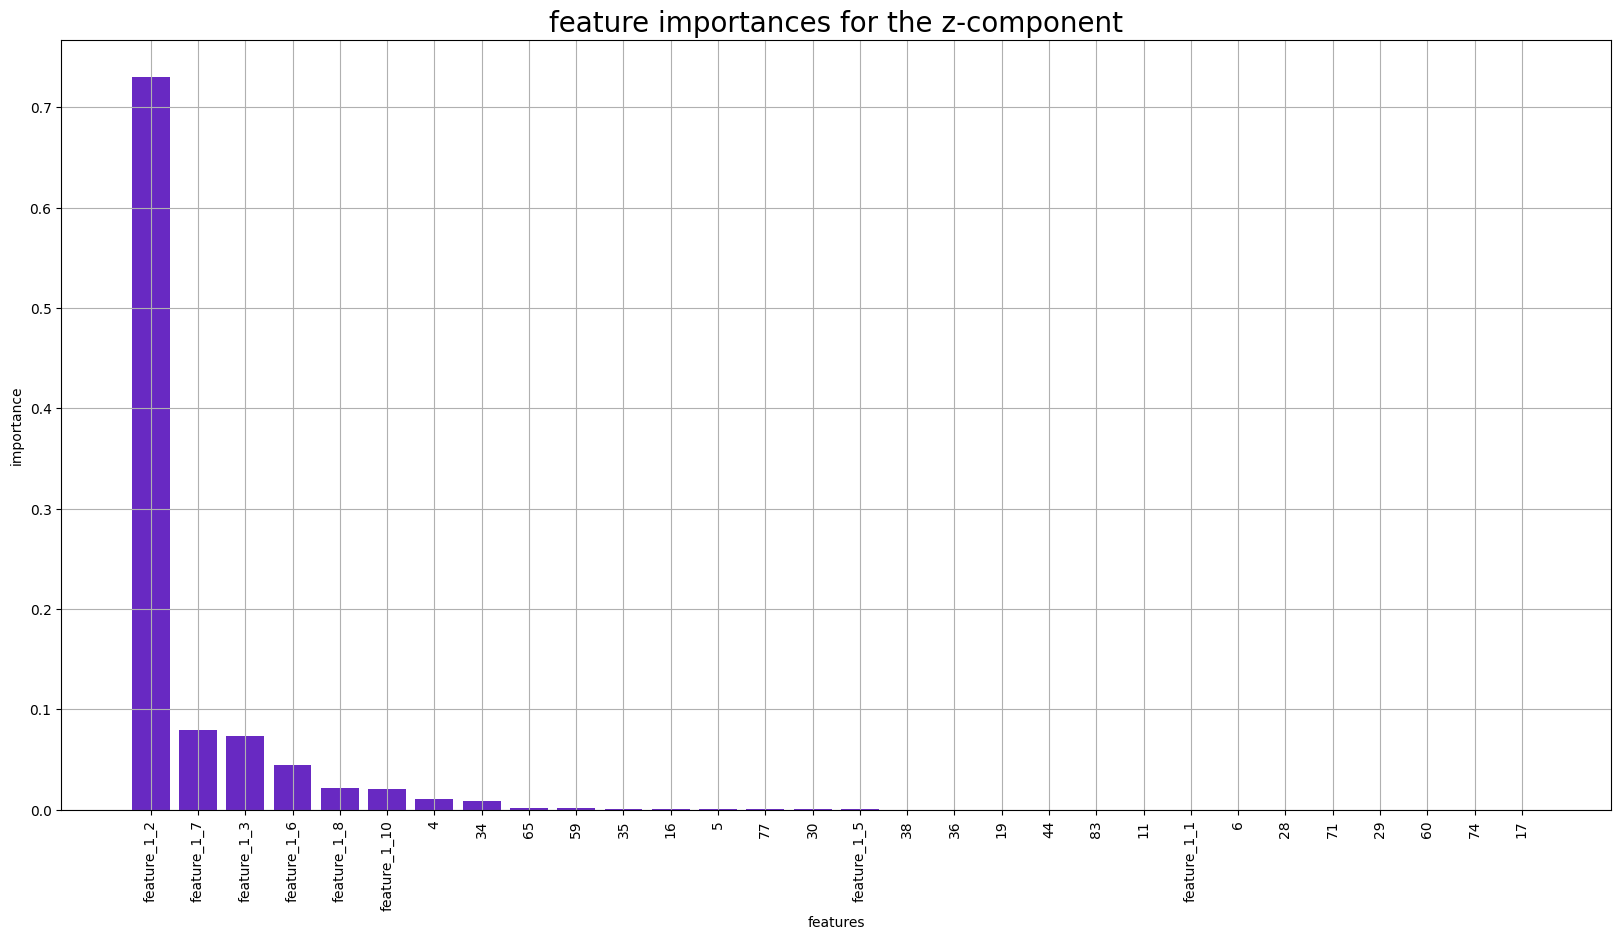

In [18]:


plt.subplots(figsize=(20, 10))

names, importances = pipe1.features.importances(target_num=2)

plt.bar(names[0:30], importances[0:30], color='#6829c2')

plt.title("feature importances for the z-component", size=20)
plt.grid(True)
plt.xlabel("features")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()


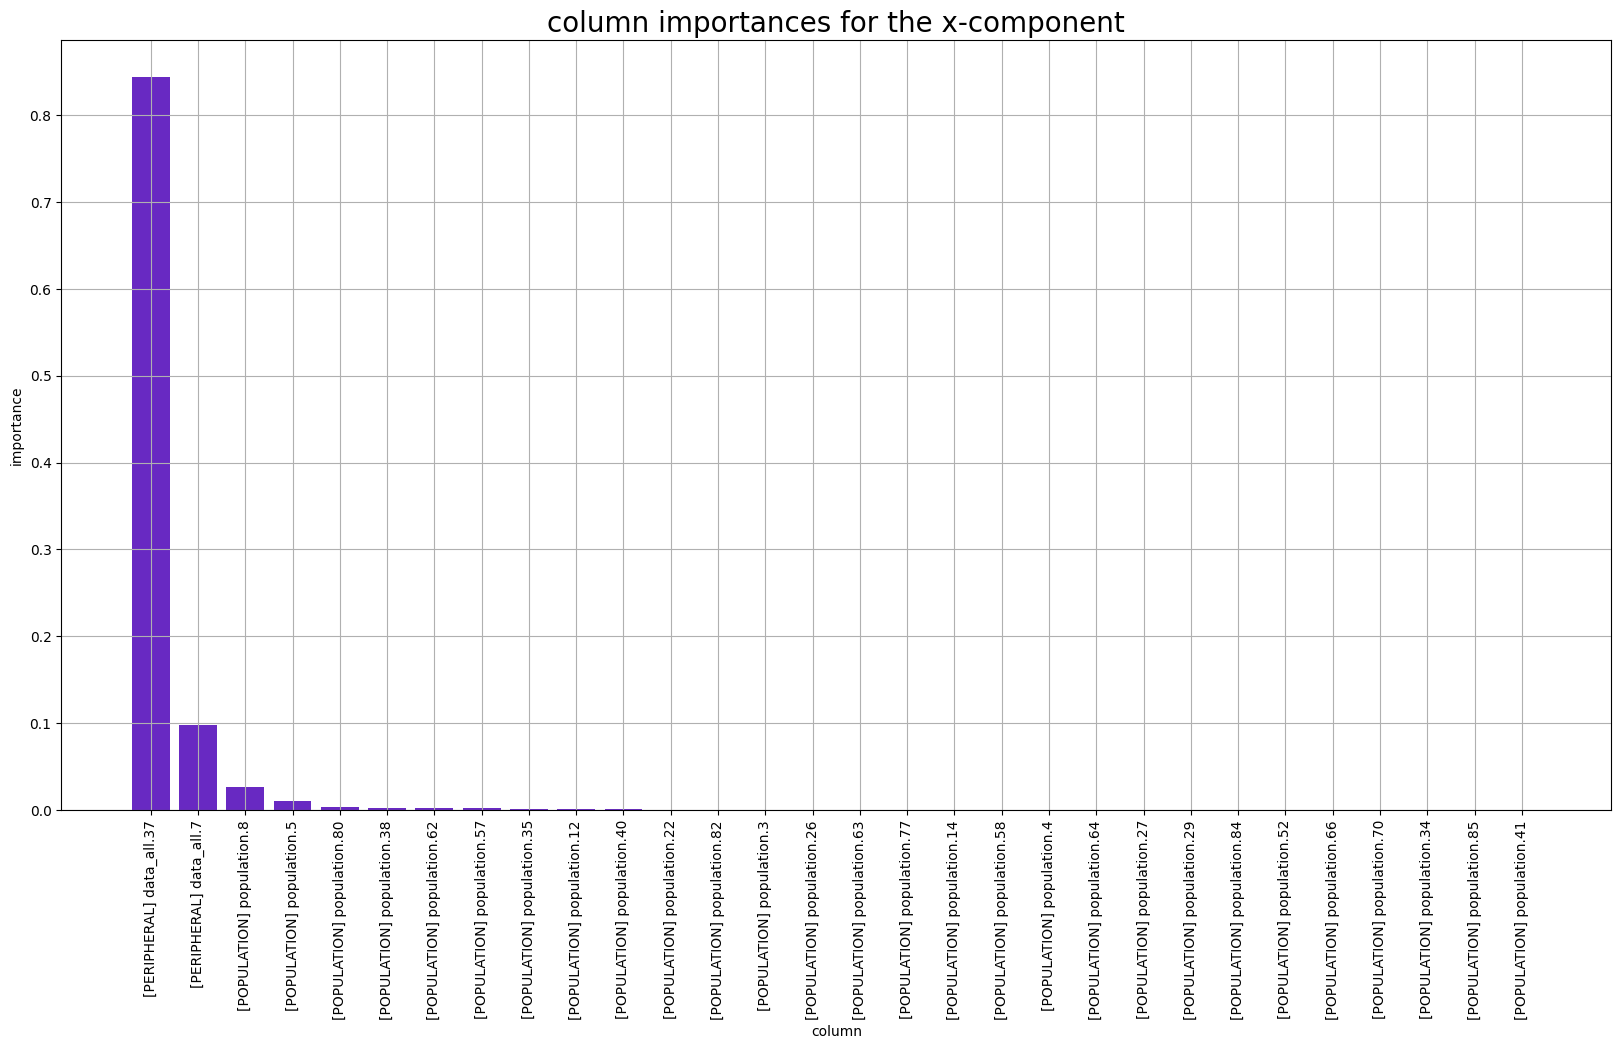

In [19]:
plt.subplots(figsize=(20, 10))

names, importances = pipe1.columns.importances(target_num=0)

plt.bar(names[0:30], importances[0:30], color='#6829c2')

plt.title("column importances for the x-component", size=20)
plt.grid(True)
plt.xlabel("column")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()

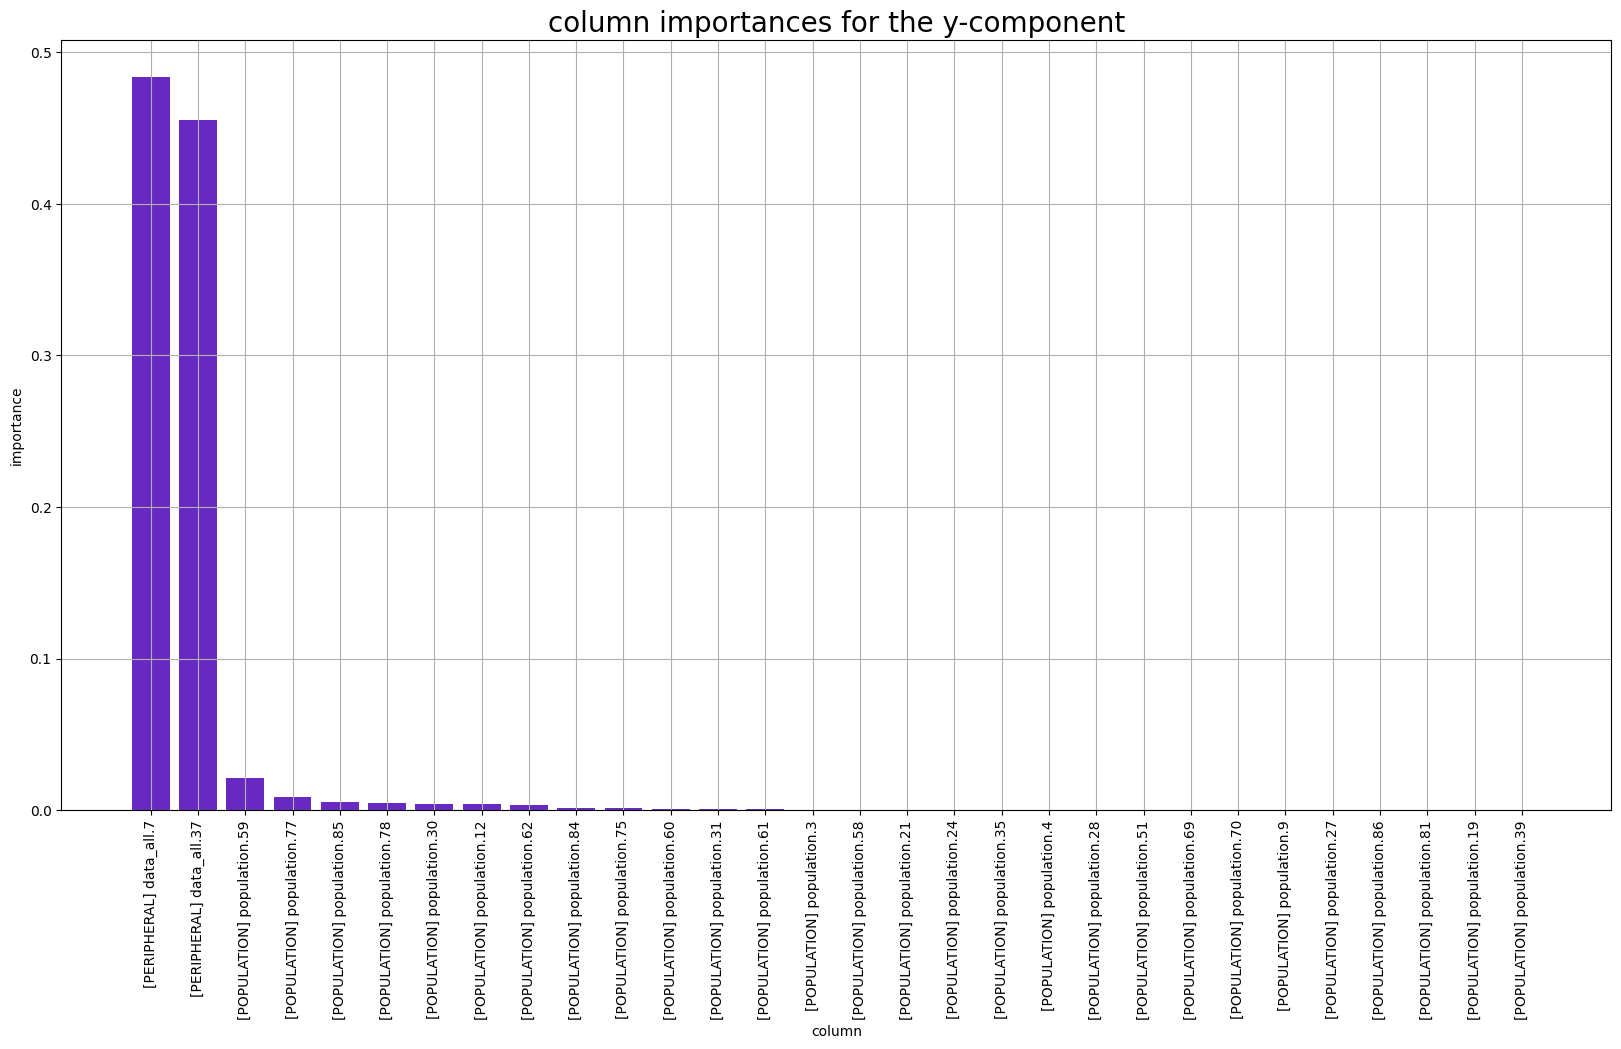

In [20]:
plt.subplots(figsize=(20, 10))

names, importances = pipe1.columns.importances(target_num=1)

plt.bar(names[0:30], importances[0:30], color='#6829c2')

plt.title("column importances for the y-component", size=20)
plt.grid(True)
plt.xlabel("column")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()

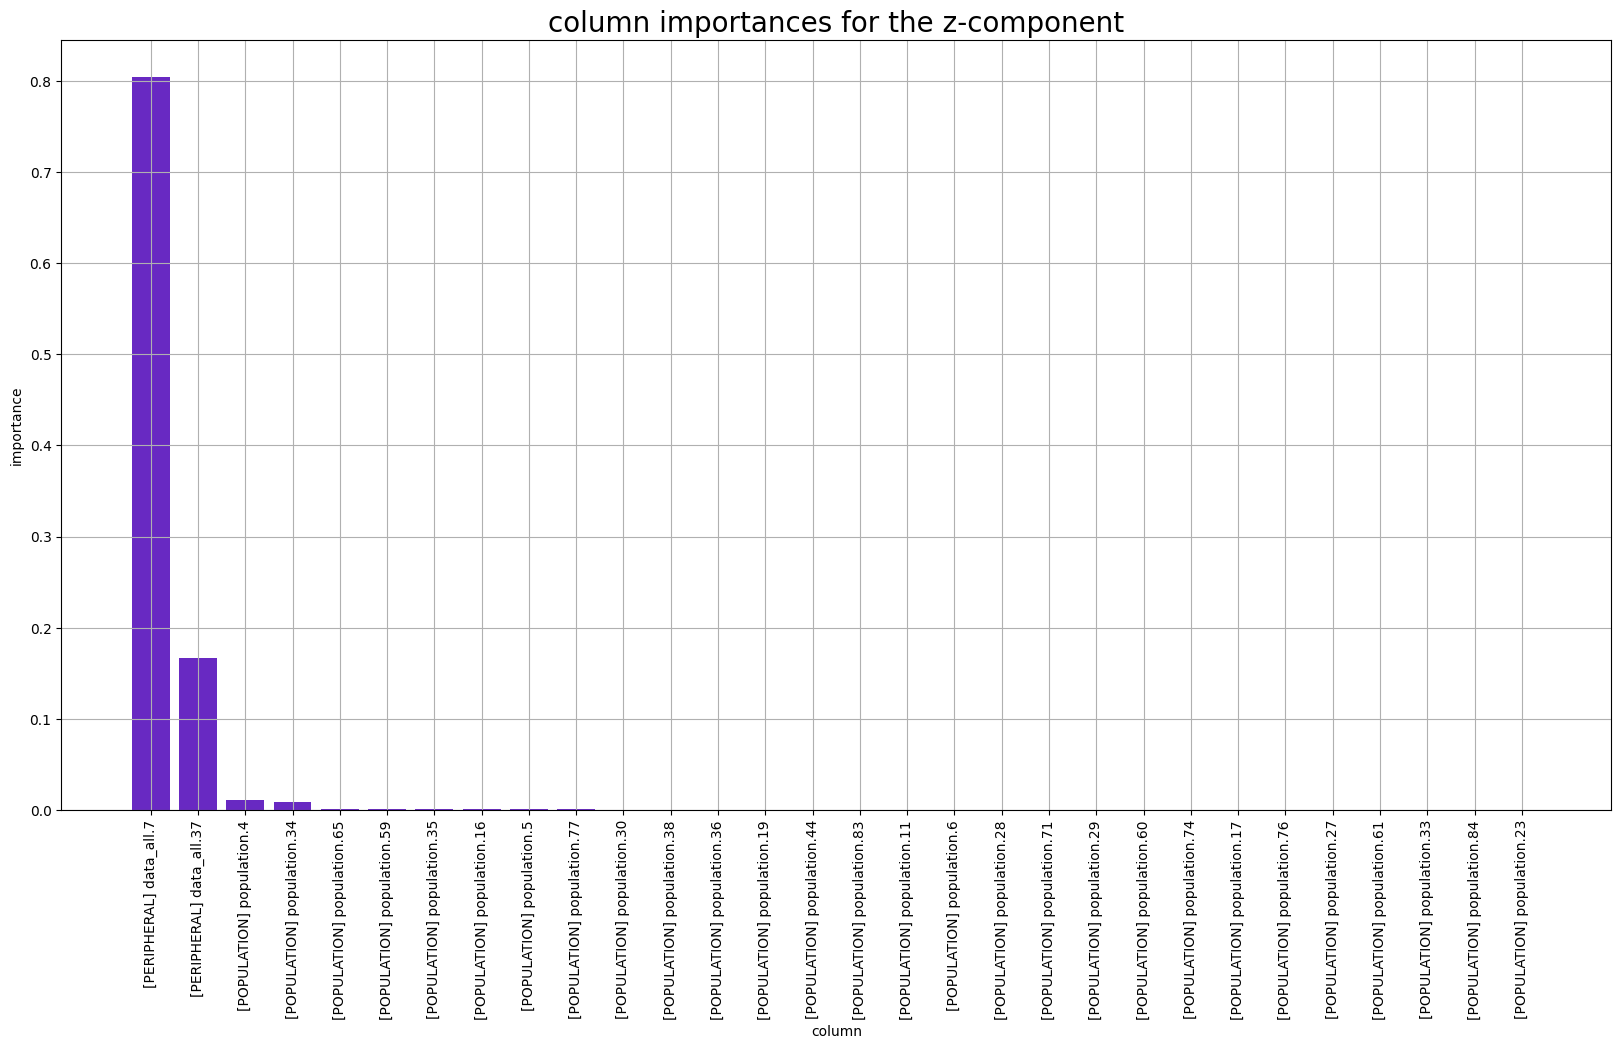

In [21]:


plt.subplots(figsize=(20, 10))

names, importances = pipe1.columns.importances(target_num=2)

plt.bar(names[0:30], importances[0:30], color='#6829c2')

plt.title("column importances for the z-component", size=20)
plt.grid(True)
plt.xlabel("column")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()
